### Backup 1: Applying hard constraints

For some problems, it is advantageous to apply prior knowledge about the solution in the network architecture, instead of the training process via additional loss terms. For example, in simple domains a Dirichlet boundary condition could be added to the network output with a corresponding characteristic function. Since the boundary condition is then naturally fulfilled, one has to consider fewer terms in the final loss and the optimization may become easier.

Here we consider the example: 
\begin{align*}
    \partial_y u(x,y) &= \frac{u(x,y)}{y}, \text{ in } [0, 1] \times [0, 1] \\
    u_1(x, 0) &= 0 , \text{ for } x \in [0, 1] \\
    u_2(x, 1) &= \sin(20\pi*x) , \text{ for } x \in [0, 1] \\
    \vec{n} \nabla u(x, y) &= 0 , \text{ for } x \in \{0, 1\}, y \in \{0, 1\}\\
\end{align*}

This problem has the simple solution $u(x, y) = y\sin(20\pi x)$. But because of the high frequencies of the sinus term, a training of the boundary condition is rather problematic. One reason for this is the usage of the MSE inside the loss function, which promotes to just learn the mean value of our boundary function. Another reason is the spectral bias of neural networks.

In the following, the problem is firstly implemented the normal way, where all above equations are used to define different loss terms. This will not lead to a correct/useful solution. (Until the first results, no comments will be given regarding the implementation. Since just the basics are used)

In [10]:
!pip install torchaudio==0.13.0
!pip install torchphysics

In [11]:
import torchphysics as tp
import pytorch_lightning as pl
import torch
import math

# Parameter of the problem
width, height = 1.0, 1.0
frequenz = 20.0 * math.pi

def bc_fn(x):
    return torch.cos(frequenz*x)

In [12]:
# First we define the space and domain:
X = tp.spaces.R1('x')
Y = tp.spaces.R1('y')
XY = X*Y
U = tp.spaces.R1('u')


x_axis = tp.domains.Interval(X, 0, 1)
y_axis = tp.domains.Interval(Y, 0, 1)
square = tp.domains.Parallelogram(XY, [0, 0], [1, 0], [0, 1])

In [13]:
# TODO: Create the samplers for the boundary and inside the domain. The boundary samplers, 
# should sample either for the left and right boundary(x_sampler), or for the top and bottom (y_sampler)
inner_sampler = ...
y_sampler = ...
x_sampler = ...

In [14]:
model = tp.models.FCN(input_space=XY, output_space=U, hidden=(50, 50, 50, 50))

First we try to learn the solution without any extensions of the generall PINN approach, e.g. we just use all
conditions for training.

In [15]:
tol = 0.0001 # to not devide by small numbers if y is close to 0

def pde_residual(u, y):
    # TODO implement the PDE
    return 

pde_condition = tp.conditions.PINNCondition(module=model,
                                            sampler=inner_sampler,
                                            residual_fn=pde_residual,
                                            name='pde_condition')

In [16]:
def dirichlet_residual(u, x, y):
    return u - y * bc_fn(x)

# TODO: add the PINNCondition for the Dirichlet boundary
dirichlet_condition = ...

In [17]:
def neumann_residual(u, x):
    return tp.utils.grad(u, x) # = 0

neumann_condition = tp.conditions.PINNCondition(module=model,
                                                sampler=x_sampler,
                                                residual_fn=neumann_residual,
                                                name='neuman_condition', weight=1/60)

In [18]:
# Start to train all 3 conditions:
optim = tp.OptimizerSetting(optimizer_class=torch.optim.Adam, lr=0.001)

solver = tp.solver.Solver([pde_condition, dirichlet_condition, neumann_condition], optimizer_setting=optim)

trainer = pl.Trainer(gpus=1,
                     max_steps=5000,
                     logger=False,
                     benchmark=True,
                     enable_checkpointing=False)
                     
trainer.fit(solver)

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3]



  | Name             | Type       | Params
------------------------------------------------
0 | train_conditions | ModuleList | 7.9 K 
1 | val_conditions   | ModuleList | 0     
------------------------------------------------
7.9 K     Trainable params
0         Non-trainable params
7.9 K     Total params
0.031     Total estimated model params size (MB)


Validation sanity check: 0it [00:00, ?it/s]

/home/tomfre/miniconda3/envs/bosch/lib/python3.9/site-packages/pytorch_lightning/utilities/distributed.py:69: UserWarning: The dataloader, val dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 20 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  warnings.warn(*args, **kwargs)
/home/tomfre/miniconda3/envs/bosch/lib/python3.9/site-packages/pytorch_lightning/utilities/distributed.py:69: UserWarning: The dataloader, train dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 20 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  warnings.warn(*args, **kwargs)


Training: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

The training was done with Adam and a learning rate of 0.001 and just for 5000 iterations. But just choosing a different algorithm or lr values will not improve the results easily. The loss will in general hover around some constant value near 0.25.

Having a look at the learned solution, most of the time we either get a solution that is close to zero or has just captured a few oscillations of the boundary function.

/home/tomfre/miniconda3/envs/bosch/lib/python3.9/site-packages/torch/functional.py:478: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at  ../aten/src/ATen/native/TensorShape.cpp:2895.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]
/home/tomfre/Desktop/torchphysics/src/torchphysics/problem/domains/domain2D/parallelogram.py:134: UserWarning: The use of `x.T` on tensors of dimension other than 2 to reverse their shape is deprecated and it will throw an error in a future release. Consider `x.mT` to transpose batches of matricesor `x.permute(*torch.arange(x.ndim - 1, -1, -1))` to reverse the dimensions of a tensor. (Triggered internally at  ../aten/src/ATen/native/TensorShape.cpp:2985.)
  bary_coords = torch.stack(torch.meshgrid((x, y))).T.reshape(-1, 2)
/home/tomfre/Desktop/torchphysics/src/torchphysics/utils/plotting/plot_functions.py:416: UserWarning: Creating a tensor from a list of 

Text(0.5, 1.0, 'learned solution')

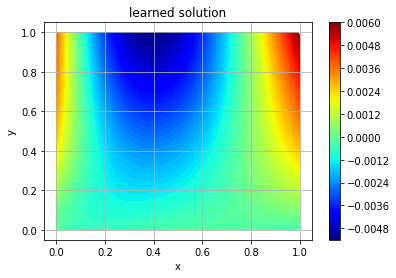

In [19]:
import matplotlib.pyplot as plt
plot_sampler = tp.samplers.PlotSampler(plot_domain=square, n_points=2000)
fig = tp.utils.plot(model, lambda u: u, plot_sampler, plot_type='contour_surface')
plt.title('learned solution')

We can also plot the error, since we know the analytical solution.

Text(0.5, 1.0, 'error')

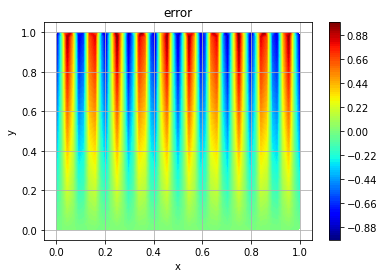

In [20]:
plot_sampler = tp.samplers.PlotSampler(plot_domain=square, n_points=2000)
fig = tp.utils.plot(model, lambda u,x,y: u-torch.cos(20*math.pi*x)*y, plot_sampler, plot_type='contour_surface')
plt.title('Error')

Now, we want to build the boundary condition into out network.
We start by resetting our network (defining a new one). With fewer parameters, because we implement the high frequencies via hard constrains and therefore the network now has to learn a simpler function.

For the hard constraints, we create the following python-function, where we choose the ansatz to just multiply the network output with the boundary function:

In [21]:
model = tp.models.FCN(input_space=XY, output_space=U, hidden=(10, 10))

def constrain_fn(u, x):
    return u*bc_fn(x)

The hard constraints now have to be always be applied inside our residual functions of the different conditions. One important point is, that our constraints do not automatically fulfill any boundary condition. So we still have all previous conditions.

Choosing for example the constraint:
, would naturally fulfill the boundary condition at . What we choose is somewhat arbitrary, important for this problem is that the oscillation appears in the constrain function.

In [22]:
def pde_residual(u, x, y):
    u = constrain_fn(u, x) # plug in output of model to apply constraint
    return tp.utils.grad(u, y) - u/(y + tol)

pde_condition = tp.conditions.PINNCondition(module=model,
                                            sampler=inner_sampler,
                                            residual_fn=pde_residual,
                                            name='pde_condition')

# TODO: Implement Dirichlet and Neumann residual and condition
def dirichlet_residual(u, x, y):
    return 

dirichlet_condition = ...

def neumann_residual(u, x):
    return 

neumann_condition = ...

In [23]:
optim = tp.OptimizerSetting(optimizer_class=torch.optim.Adam, lr=0.001)

solver = tp.solver.Solver([pde_condition, dirichlet_condition, neumann_condition], optimizer_setting=optim)

trainer = pl.Trainer(gpus=1,
                     max_steps=5000,
                     logger=False,
                     benchmark=True,
                     checkpoint_callback=False)
                     
trainer.fit(solver)

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3]

  | Name             | Type       | Params
------------------------------------------------
0 | train_conditions | ModuleList | 151   
1 | val_conditions   | ModuleList | 0     
------------------------------------------------
151       Trainable params
0         Non-trainable params
151       Total params
0.001     Total estimated model params size (MB)


Validation sanity check: 0it [00:00, ?it/s]

/home/tomfre/miniconda3/envs/bosch/lib/python3.9/site-packages/pytorch_lightning/utilities/distributed.py:69: UserWarning: The dataloader, val dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 20 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  warnings.warn(*args, **kwargs)
/home/tomfre/miniconda3/envs/bosch/lib/python3.9/site-packages/pytorch_lightning/utilities/distributed.py:69: UserWarning: The dataloader, train dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 20 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  warnings.warn(*args, **kwargs)


Training: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Text(0.5, 1.0, 'learned solution')

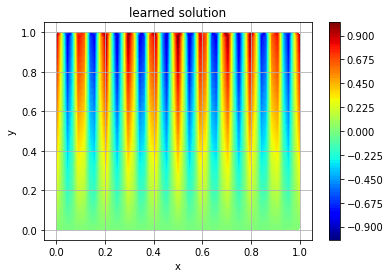

In [24]:
plot_sampler = tp.samplers.PlotSampler(plot_domain=square, n_points=2000)
fig = tp.utils.plot(model, constrain_fn, plot_sampler, plot_type='contour_surface')
plt.title('learned solution')

Text(0.5, 1.0, 'Error')

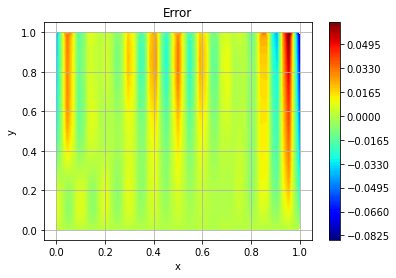

In [25]:
plot_sampler = tp.samplers.PlotSampler(plot_domain=square, n_points=2000)
fig = tp.utils.plot(model, lambda u,x,y: constrain_fn(u,x)-torch.cos(20*math.pi*x)*y, plot_sampler, plot_type='contour_surface')
plt.title('Error')